# ModelOptions vs SolverOptions


The distinction between **`ModelOptions`** and **`SolverOptions`** is essential when working with `OptiWindNet`.
This notebook presents a clear and structured explanation of their roles and differences:

- **`ModelOptions`** define *how the optimization problem is formulated*, including structural assumptions and model features such as topology type, feeder constraints, and balancing requirements.
- **`SolverOptions`** configure *how the underlying solver behaves during execution*, controlling aspects like time limits, optimality gaps, and so on.

Understanding this separation helps ensure that models are both correctly formulated and efficiently solved.

## 🔧 What is `ModelOptions`?

`ModelOptions` is a configuration object or dictionary that **controls how the mathematical model is built and behaves**, regardless of the solver used. These options are typically **high-level**, problem-specific settings that:

* Affect the **structure** of the model (e.g., topology type)
* Enable or disable **features** (e.g., balancing constraints)
* Influence **heuristic/metaheuristic behavior** if used

#### ✅ Parameters in `ModelOptions`:

| Parameter      | Description                                                                 |
| -------------- | --------------------------------------------------------------------------- |
| `topology`     | Controls whether the solution allows "radial" or "branched" subtrees        |
| `feeder_route` | Determines if feeder paths must be "straight" or may be "segmented"         |
| `feeder_limit` | Specifies limits on the number of feeders used in the solution              |
| `balanced`     | Whether subtree loads must be balanced                                      |
| `max_feeders`  | Required when `feeder_limit="specified"` to indicate the max number allowed |

These options **change the formulation** of the problem before it is handed to the solver.

### Capability of different routers

| Router           | Topology                                                              | Feeder Route                                                      | Feeder Limit                                                    |
|------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------|------------------------------------------------------------------|
| **EWRouter**      | Not user-controllable | Controllable via `feeder_route` parameter | Not user controllable                                                 |
| **HGSRouter**  | Always produces *radial* topology                                     | Not user-controllable | Controllable via `feeder_limit` parameter             |
| **MILPRouter**           | Controllable via `topology` parameter in `ModelOptions`         | Controllable via `feeder_route` parameter in `ModelOptions`                   | Controllable via `feeder_limit` parameter in `ModelOptions`   |


Import required functions

In [1]:
from optiwindnet.api import WindFarmNetwork, EWRouter, HGSRouter, MILPRouter, ModelOptions

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

Access ModelOptions help

In [3]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



Optimize an examplary location

In [4]:
wfn = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=[(2, 1500.0), (5, 1800.0), (7, 2000.0)])

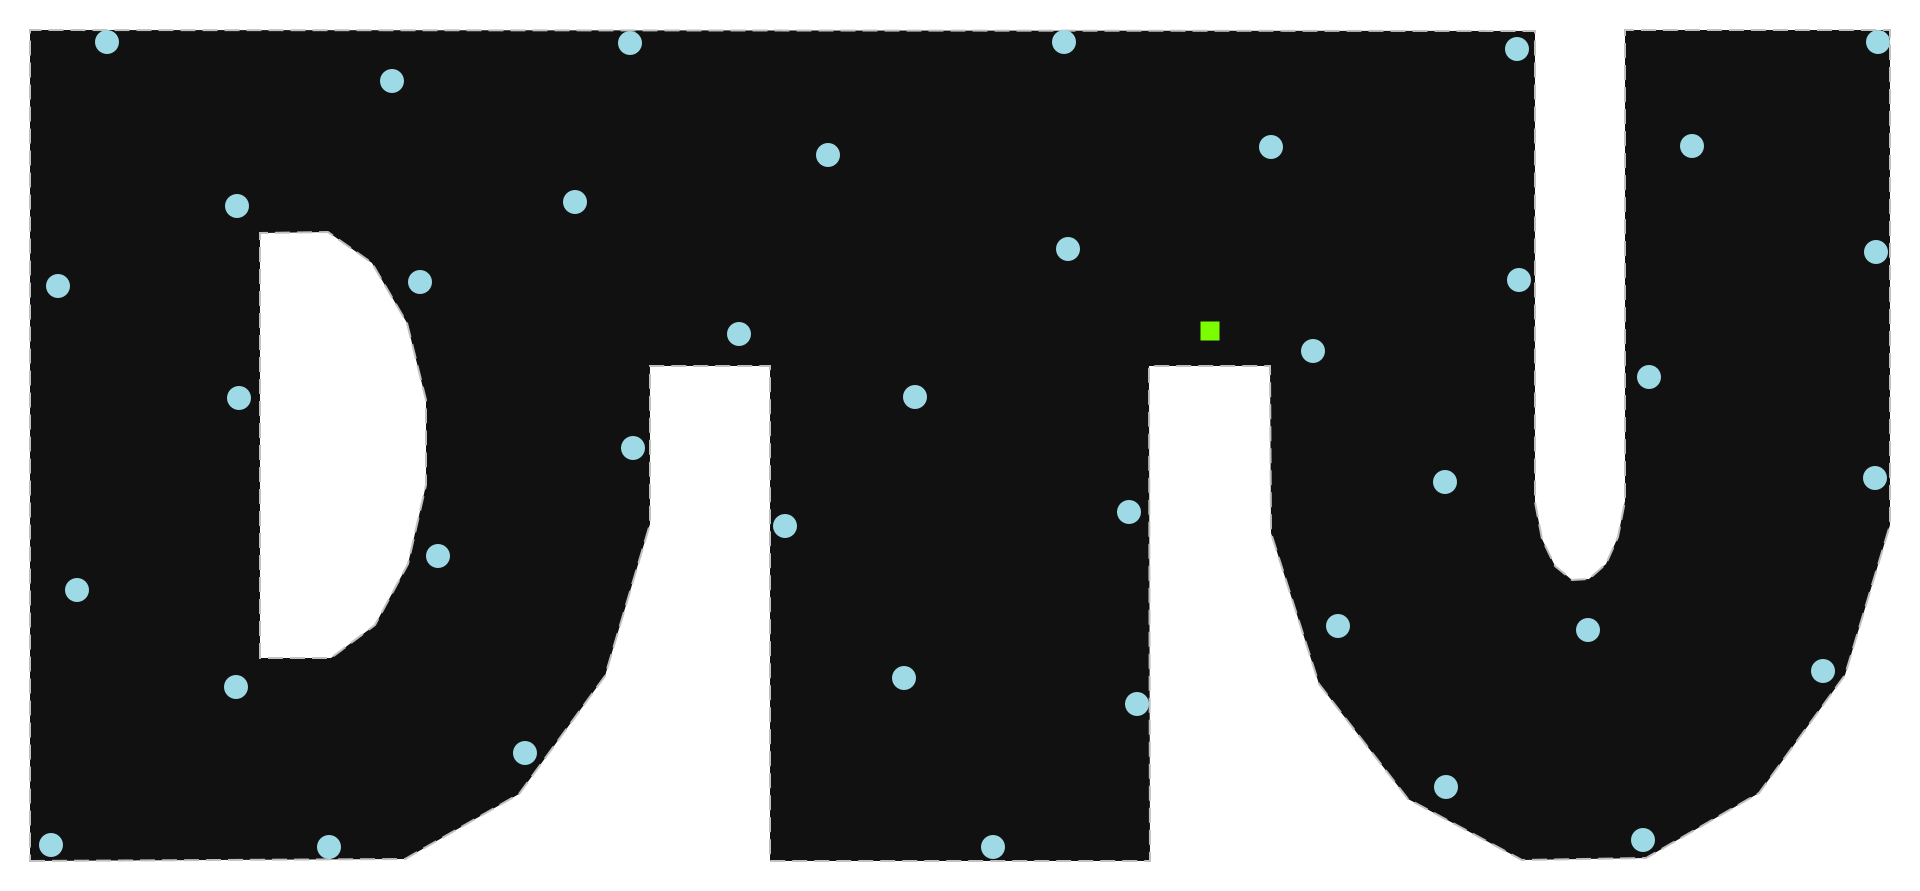

In [5]:
wfn

### EWRouter

* This router does not accept `ModelOptions` as an argument.
* The optional EWRouter() parameter `feeder_route` can be set to `'segmented'` (default) or `'straight'`.

Example using `feeder_route='segmented'`

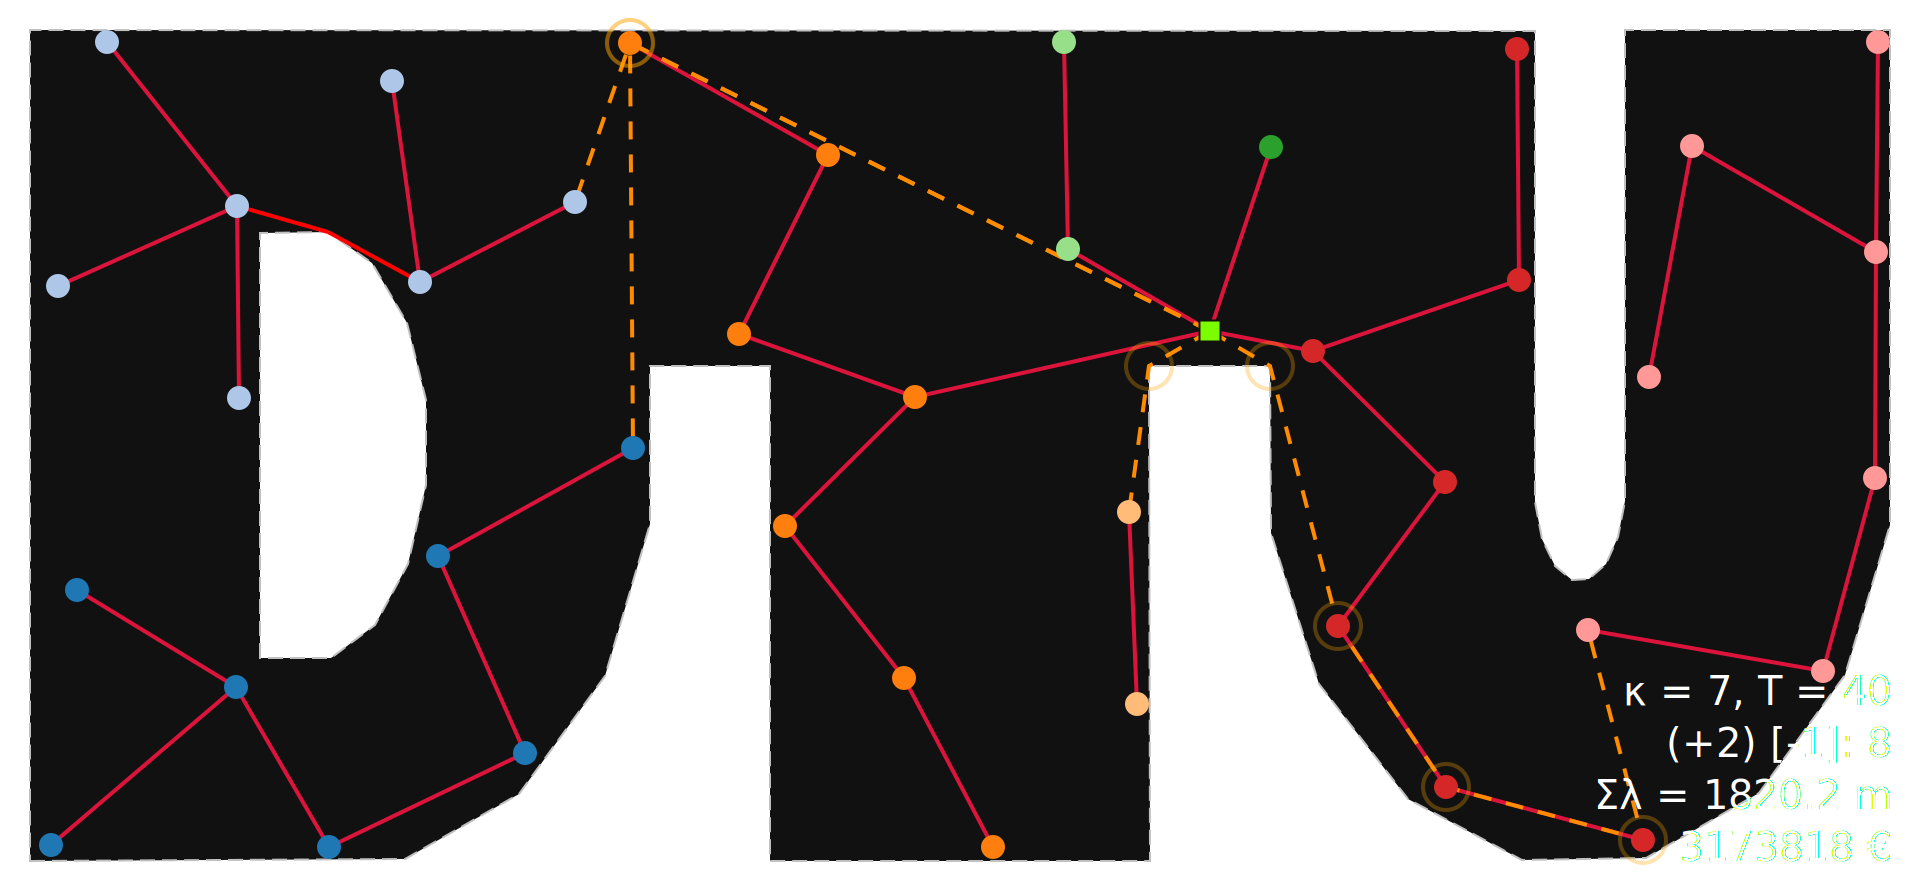

In [6]:
terse = wfn.optimize(router=EWRouter())
wfn

Example using `feeder_route='straight'`

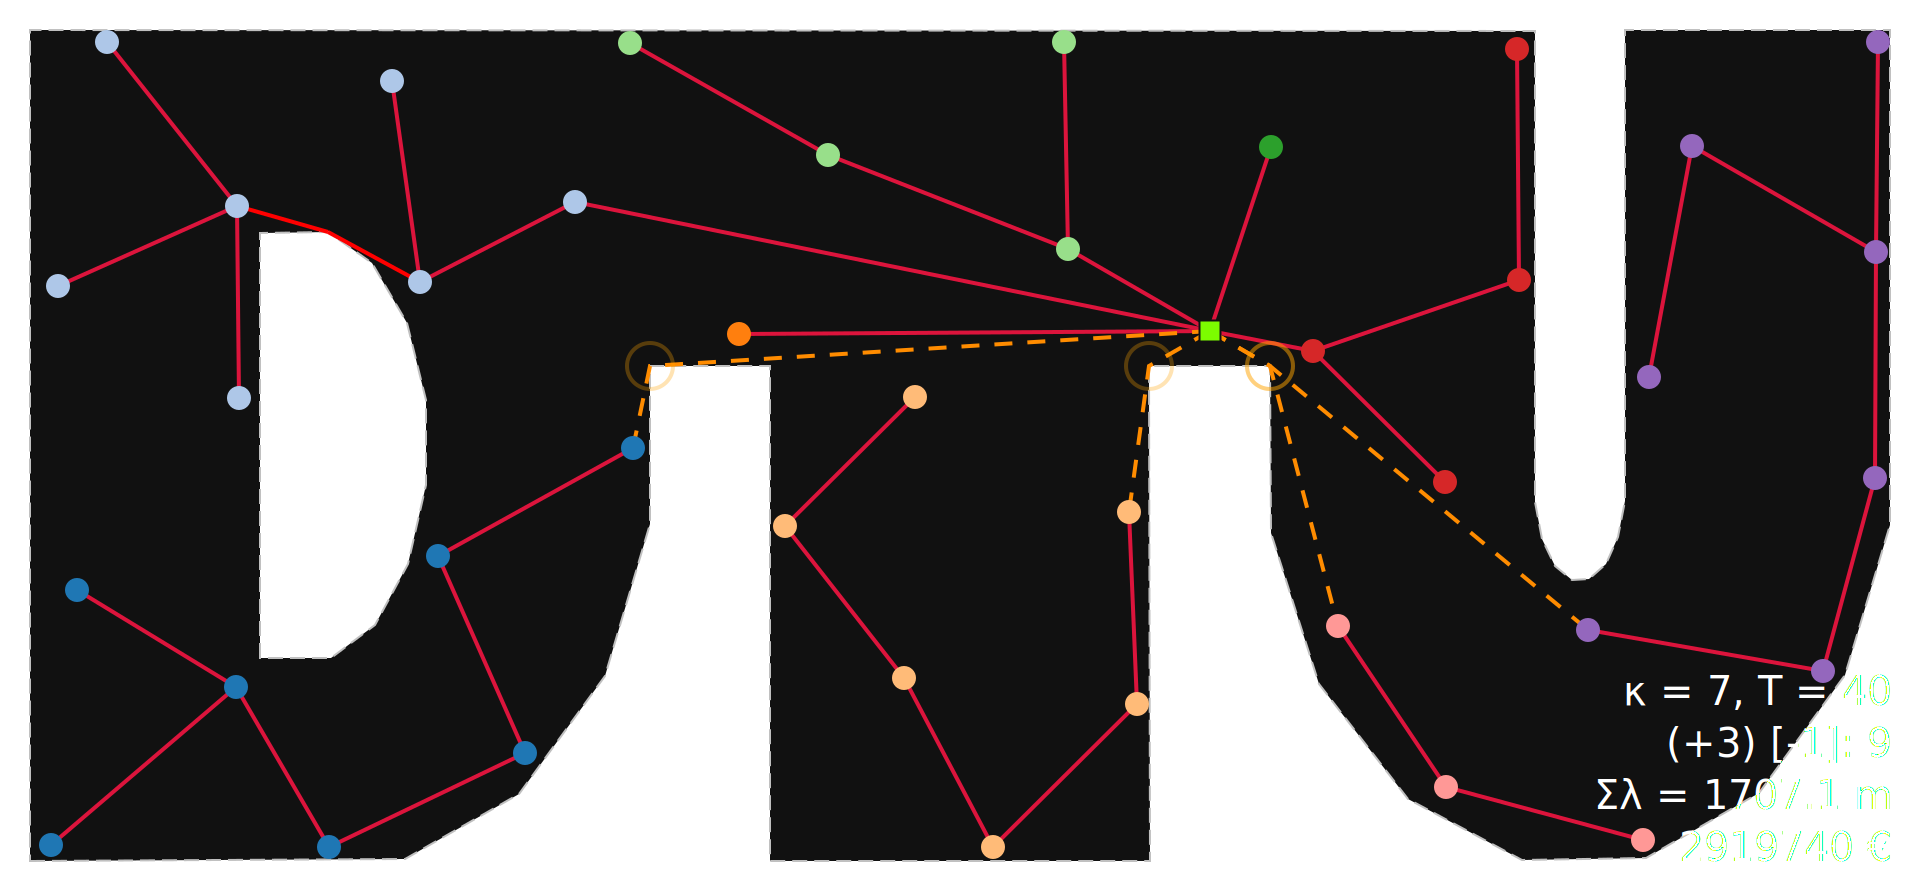

In [7]:
terse = wfn.optimize(router=EWRouter(feeder_route='straight'))
wfn

### HGSRouter

`HGSRouter` does not support `ModelOptions` in its current format. Instead, it accepts key configuration options, such as `feeder_limit` and `balanced`, as individual arguments passed directly to the router.

* Default values:

  * `balanced = False`
  * `feeder_limit` is flexible and generally favors minimizing total cable length:

    * For locations with one substation, `feeder_limit` can be adjusted.
    * For locations with multiple substations, the `feeder_limit` argument is *ignored*, and the number of feeders is fixed to the minimum required.
  * Other `ModelOptions` parameters, such as `topology` (HGSRouter always generates *radial topologies*) and `feeder_route`, are not currently supported.

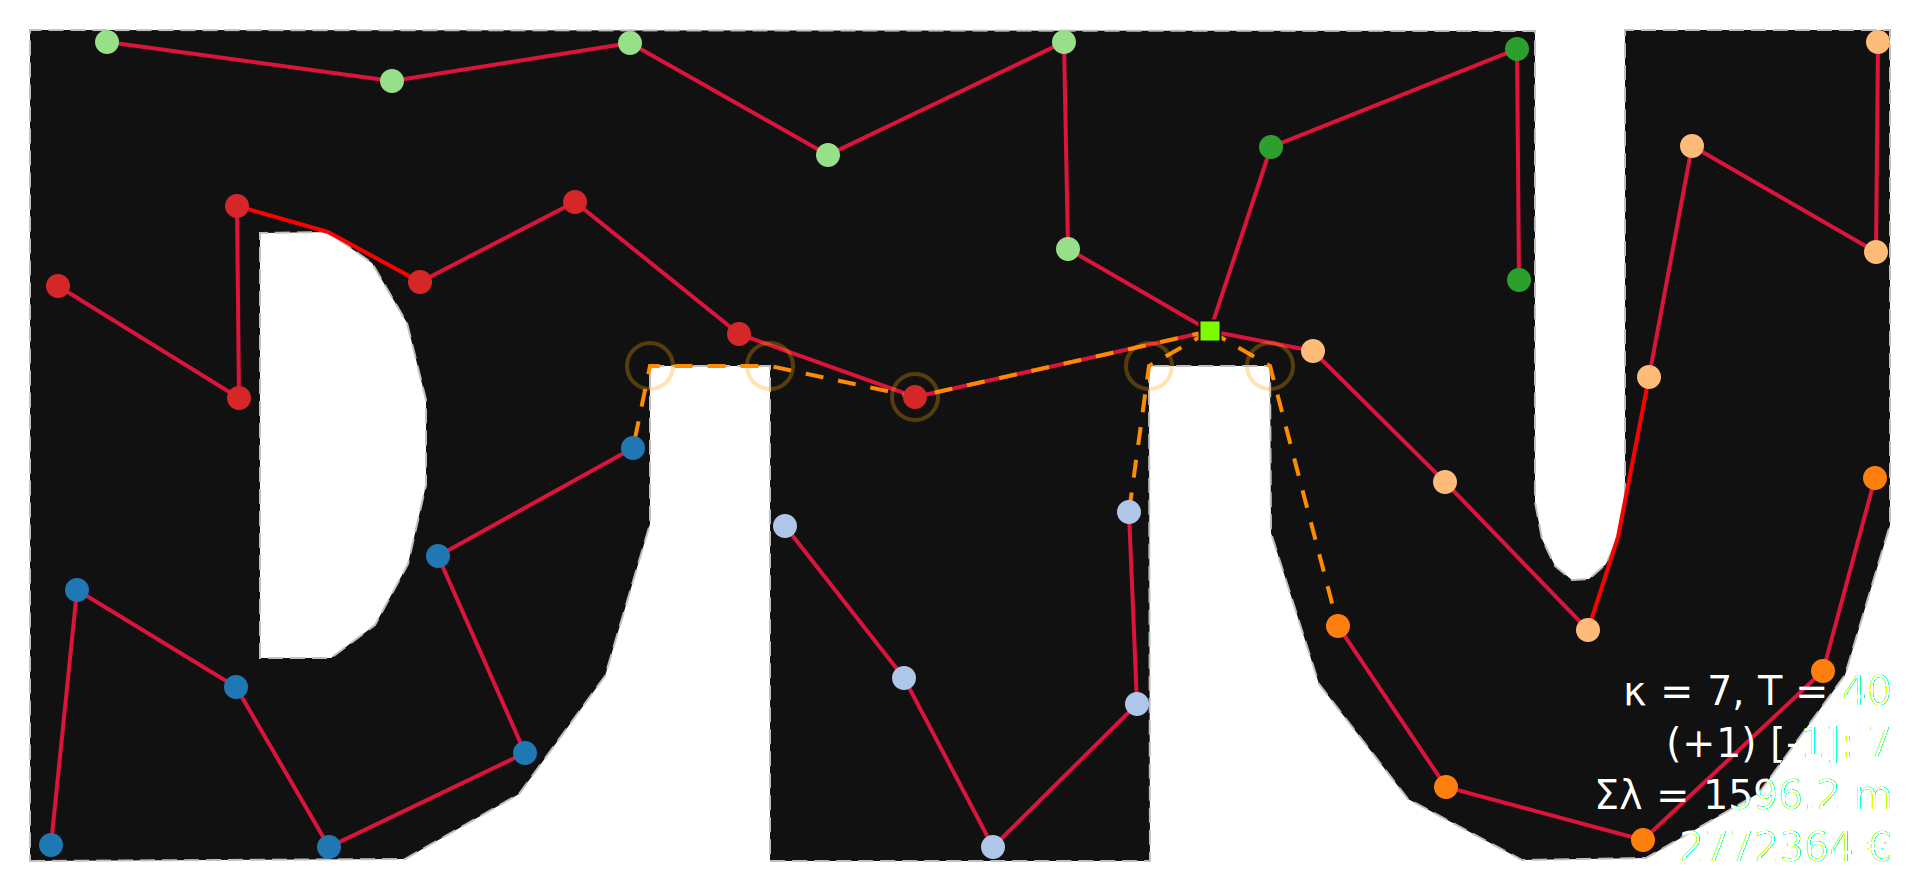

In [8]:
hgs_router = HGSRouter(time_limit=2)
terse = wfn.optimize(router=hgs_router)
wfn

Set the `feeder_limit` lower than the possible minimum.

Vehicle number (0) too low for feasibilty with capacity (7). Setting to 6.


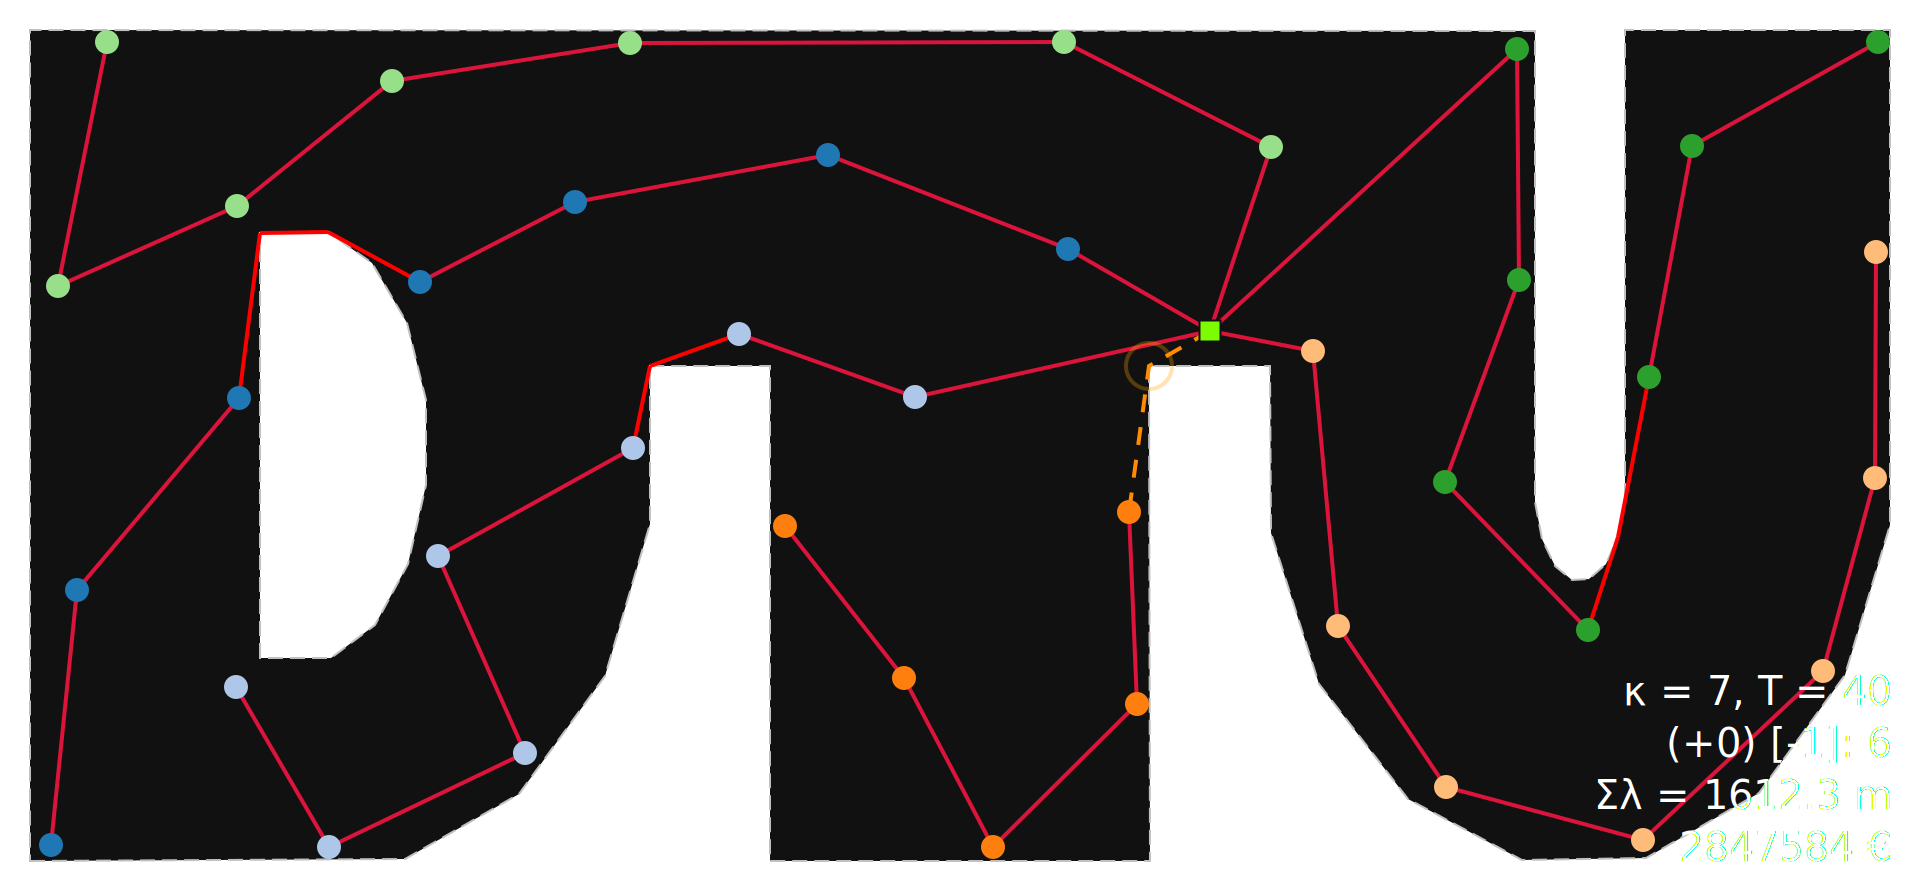

In [9]:
hgs_router2 = HGSRouter(time_limit=2, feeder_limit=0)
terse = wfn.optimize(router=hgs_router2)
wfn

### MILP routers

`MILPRouter` is able to control all settings in `ModelOption`.

In this notebook, we run optimization with two sets of ModelOptions for comparison:


| Model Option   | Set 1       | Set 2       |
| -------------- | ----------- | ----------- |
| **topology**     | `branched`  | `radial`    |
| **feeder_limit** | `unlimited` | `minimum`   |
| **feeder_route** | `segmented` | `straight` |

With `MILP`, we observe the following behavior across different `ModelOptions` settings:

#### First MILP Run (`model_options1`)

In [10]:
model_options1 = ModelOptions(
    topology='branched',
    feeder_limit='unlimited',
    feeder_route='segmented',
)

  The solver constructs a **branched** network structure without applying any limit on the number of feeders. The feeder routes follow a **segmented** (piecewise-straight) pattern, as specified. All aspects of the network are consistent with the given `ModelOptions`.

  This solution can also serve as a **valid warm start** for subsequent optimizations.

In [11]:
milp_router = MILPRouter(
    solver_name='ortools',
    time_limit=10,
    mip_gap=0.01,
    model_options=model_options1,
    verbose=True,
)

>>> No solution is available for warmstarting! <<<


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 10 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x6c7cfc6ee6d2919b)
#Variables: 708 (#bools: 354 in floating point objective) (628 primary variables)
  - 354 Booleans in [0,1]
  - 314 in [0,4]
  - 40 in [0,5]
#kAtMostOne: 262 (#literals: 776)
#kLinear1: 708 (#enforced: 708)
#kLinear3: 1
#kLinearN: 122 (#terms: 1'767)

Starting presolve at 0.00s
[Scaling] Floating point objective has 354 terms with magnitude in [18.5198, 233.655] average = 64.9611
[Scaling] Objective coefficient relative error: 2.56462e-08
[Scaling] Objective worst-case absolute error: 8.40207e-05
[Scaling] Objective scaling factor: 524288
  3.95e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.16e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening

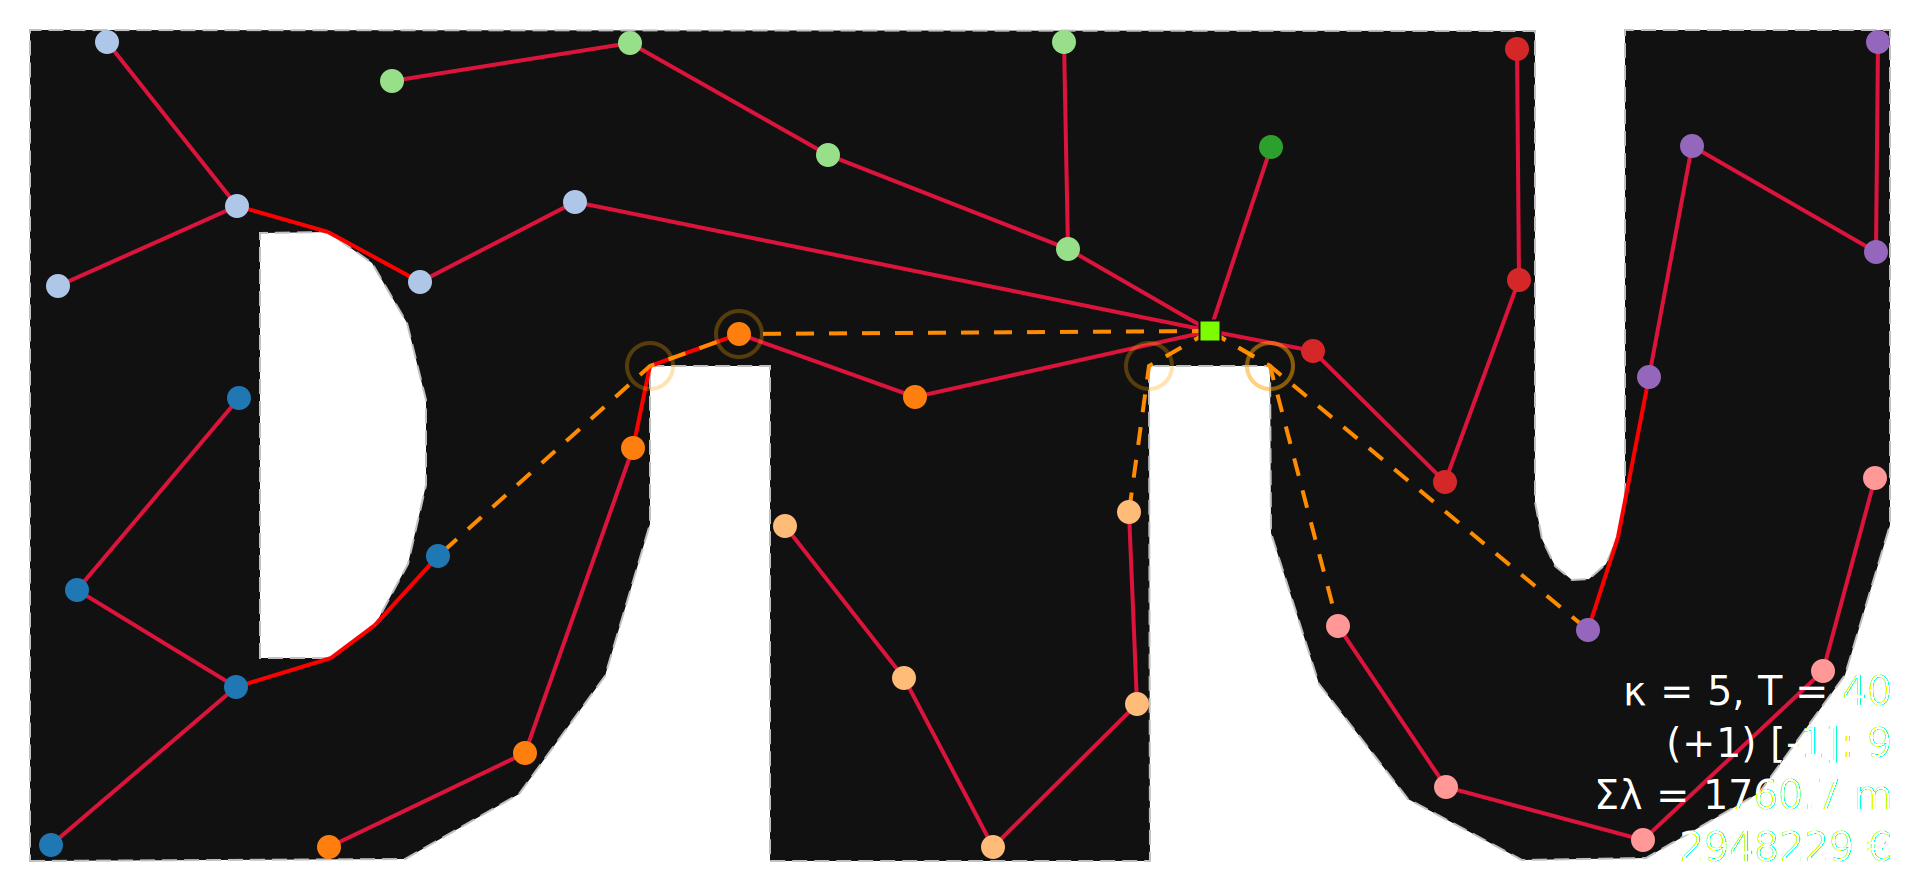

In [12]:
# lower cable capacities to cleary observe the difference between runs
wfn = WindFarmNetwork.from_pbf(
    filepath='data/DTU_letters.osm.pbf',
    cables=[(2, 1500.0), (5, 1800.0)],
)
terse = wfn.optimize(router=milp_router)
wfn

#### Second MILP Run (`model_options2`)

In [13]:
model_options2 = ModelOptions(
    topology='radial',
    feeder_limit='minimum',
    feeder_route='straight',
)

  The solver produces a strictly **radial** network, restricting the number of feeders to the minimum required given the number or turbines and maximum cable capacity. The `feeder_route='straight'` tells the solver to avoid blocking any feeder route with cables which tends to produce more **straight-line connections**, although the feeder routes may still have bends due to the exclusion zones.

  > Note: with this setting, neither EWRouter nor HGSRouter could secure warmstarting of the model.

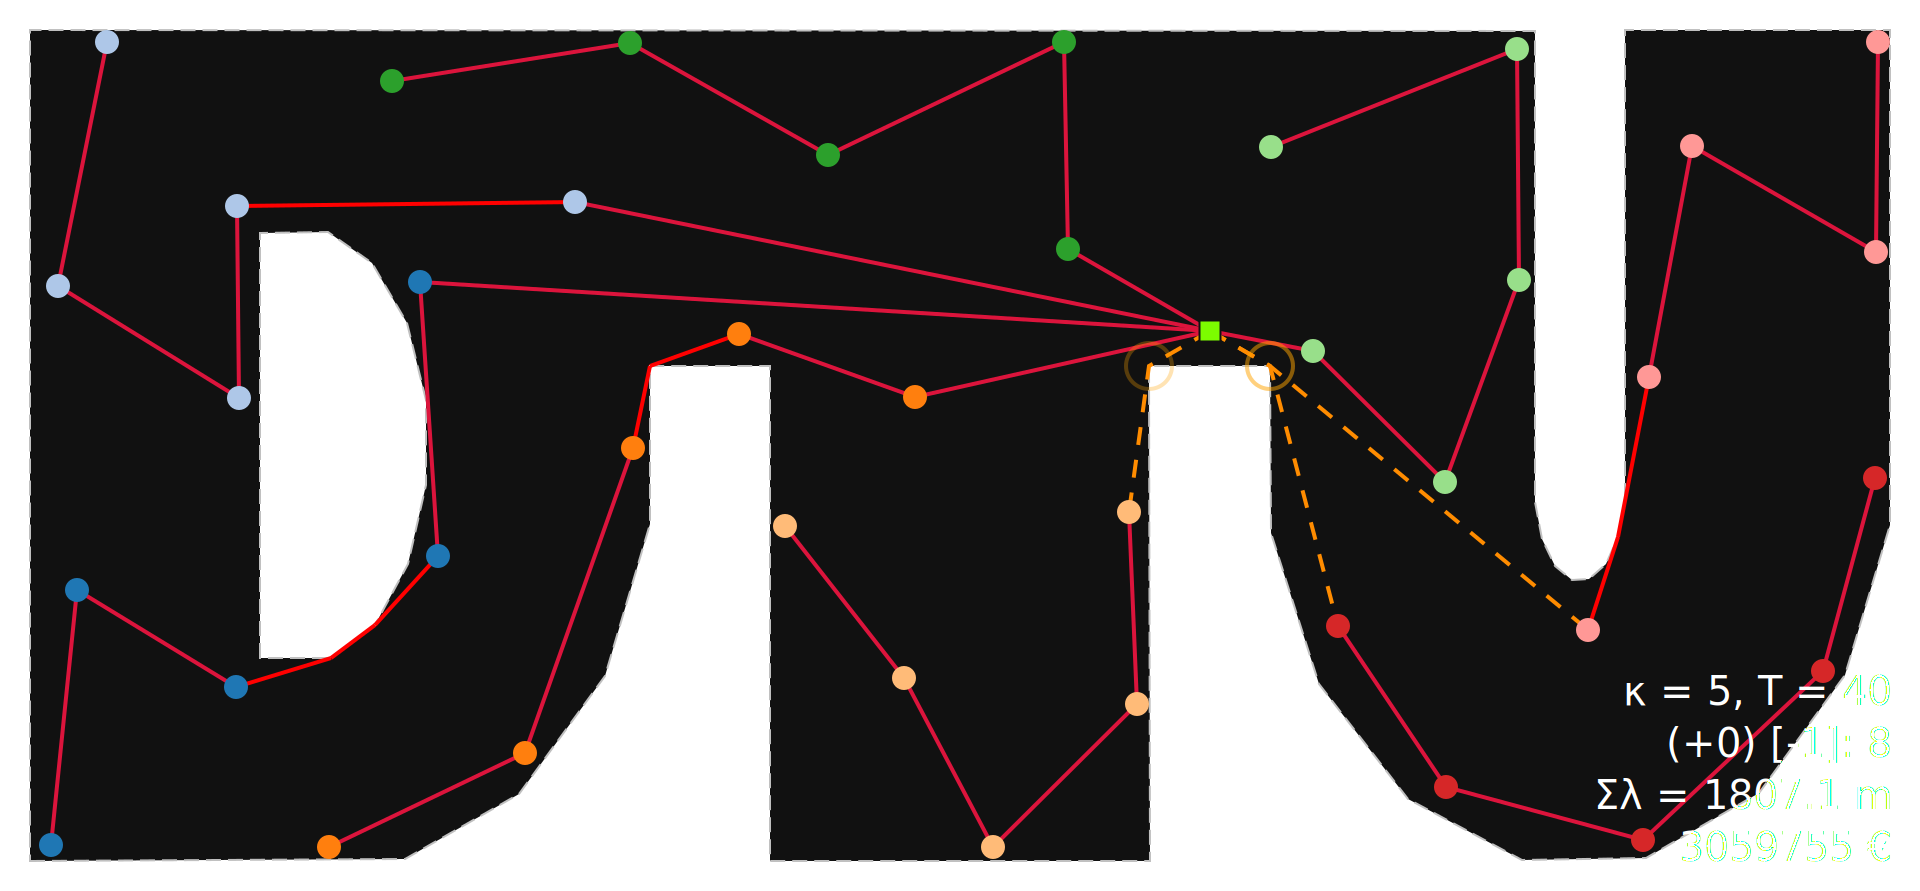

In [14]:
milp_router2 = MILPRouter(
    solver_name='ortools',
    time_limit=10,
    mip_gap=0.01,
    model_options=model_options2
)
terse = wfn.optimize(router=milp_router2)
wfn

#### Summary

The `MILP` router strictly adheres to all provided `ModelOptions`:

* It guarantees enforcement of topology (`branched` vs. `radial`).
* It respects feeder constraints (`unlimited` vs. `minimum`).
* It conforms to the required routing structure (`segmented` vs. `straight`).

#### Warmstarting of MILP routers
Warmstarter Compatibility with different `ModelOptions` setting is summarized in table below.

| **Model Option** | **Value**     | **Warmstarter**  |
|------------------|---------------|------------------|
| **Feeder limit** | Unlimited     | ✅ all works     |
|                  | Minimum       | only HGSRouter   |
| **Feeder route** | Straight      | ✅ all works     |
|                  | Segmented     | ✅ all works     |
| **Topology**     | Branched      | ✅ all works     |
|                  | Radial        | only HGSRouter   |


In the following section, a few examples are run to further illustrate this table.


Example 1:

In [15]:
model_options = ModelOptions(
    topology='branched',
    feeder_limit='unlimited',
    feeder_route='segmented',
)

In [16]:
milp_router = MILPRouter(
    solver_name='ortools',
    time_limit=1,
    mip_gap=0.01,
    model_options=model_options,
    verbose=True
)

Either EWRouter or HGSRouter can be used to warmstart.

In [17]:
wfn.optimize(router=EWRouter())
terse = wfn.optimize(router=milp_router)

Using warm start: the model is initialized with the provided solution S.


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 1 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x7950fb95aaeccb26)
#Variables: 708 (#bools: 354 in floating point objective) (628 primary variables)
  - 354 Booleans in [0,1]
  - 314 in [0,4]
  - 40 in [0,5]
#kAtMostOne: 262 (#literals: 776)
#kLinear1: 708 (#enforced: 708)
#kLinear3: 1
#kLinearN: 122 (#terms: 1'767)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 354 terms with magnitude in [18.5198, 233.655] average = 64.9611
[Scaling] Objective coefficient relative error: 2.56462e-08
[Scaling] Objective worst-case absolute error: 8.40207e-05
[Scaling] Objective scaling factor: 524288
  3.51e-04s  0.00e+00d  [DetectDominanceRelations] 
  9.90e-03s  0.00e+00d  [operations_research::sat::CpMode

Example 2:

In [18]:
model_options = ModelOptions(
    topology='radial',
    feeder_limit='unlimited',
    feeder_route='segmented',
)

In [19]:
milp_router = MILPRouter(
    solver_name='ortools',
    time_limit=1,
    mip_gap=0.01,
    model_options=model_options,
    verbose=True
)

Now the solution by EWRouter is not a feasible warmstart.

In [20]:
wfn.optimize(router=EWRouter())
terse = wfn.optimize(router=milp_router)


    - branched network incompatible with model option: topology="radial"


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 1 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x97202364a81551af)
#Variables: 708 (#bools: 354 in floating point objective) (628 primary variables)
  - 354 Booleans in [0,1]
  - 314 in [0,4]
  - 40 in [0,5]
#kAtMostOne: 262 (#literals: 776)
#kLinear1: 708 (#enforced: 708)
#kLinear3: 2
#kLinearN: 161 (#terms: 2'078)

Starting presolve at 0.00s
The solution hint is complete, but it is infeasible! we will try to repair it.
[Scaling] Floating point objective has 354 terms with magnitude in [18.5198, 233.655] average = 64.9611
[Scaling] Objective coefficient relative error: 2.56462e-08
[Scaling] Objective worst-case absolute error: 8.40207e-05
[Scaling] Objective scaling factor: 524288
  3.19e-04s  0.00e+00d  [DetectDominanceRelations] 
  6.98e-03s  0.00e+00d  

But the solution by HGSRouter can warmstart the MILPRouter.

In [21]:
wfn.optimize(router=HGSRouter(time_limit=1))
terse = wfn.optimize(router=milp_router)

Using warm start: the model is initialized with the provided solution S.


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 1 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x95d7734e903987ec)
#Variables: 708 (#bools: 354 in floating point objective) (628 primary variables)
  - 354 Booleans in [0,1]
  - 314 in [0,4]
  - 40 in [0,5]
#kAtMostOne: 262 (#literals: 776)
#kLinear1: 708 (#enforced: 708)
#kLinear3: 2
#kLinearN: 161 (#terms: 2'078)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 354 terms with magnitude in [18.5198, 233.655] average = 64.9611
[Scaling] Objective coefficient relative error: 2.56462e-08
[Scaling] Objective worst-case absolute error: 8.40207e-05
[Scaling] Objective scaling factor: 524288
  2.33e-04s  0.00e+00d  [DetectDominanceRelations] 
  5.09e-03s  0.00e+00d  [operations_research::sat::CpMode

## 🧮 What is `SolverOptions`?

`SolverOptions` refers to *solver-specific configuration parameters* that affect *how the solver works internally* (once the model is already built).

These settings are typically passed directly to a solver like CPLEX, Gurobi, CBC, etc., and influence:

    * Search strategy
    * Runtime limits
    * Optimality tolerances
    * Logging and precision settings

#### ✅ Common `SolverOptions` for `MILPRouter`:

| Parameter      | Description                                           |
| -------------- | ----------------------------------------------------- |
| `time_limit`   | Maximum allowed solve time (in seconds)               |
| `gap`          | Optimality tolerance (e.g., 0.01 for 1% gap)          |
| `mip_emphasis` | Prioritize bound quality, feasibility, or integrality |
| `threads`      | Number of threads to use                              |

After initializing the router, `OptiWindNet` sets a set of default options internally to match OptiWindNet’s preferred values.

You can see the solveroptions modified by `OptiWindNet` after creating an instance of the `MILPRouter` via:

```python
router.optiwindnet_default_options
```

>If desired, set the logging level to `INFO` *before running `.optimize()` with the MILPRouter* to display detailed messages about the solver configuration:
>```python
>import logging
>logging.basicConfig(level=logging.INFO)
>```

In [22]:
milp_router_ortools = MILPRouter(solver_name='ortools', time_limit=15, mip_gap=0.01)
milp_router_ortools.optiwindnet_default_options

{}

In [23]:
milp_router_cplex = MILPRouter(solver_name='cplex', time_limit=15, mip_gap=0.01)
milp_router_cplex.optiwindnet_default_options

{'parallel': -1, 'emphasis_mip': 4}

In [24]:
milp_router_cbc = MILPRouter(solver_name='cbc', time_limit=15, mip_gap=0.01)
milp_router_cbc.optiwindnet_default_options

{'threads': 16,
 'timeMode': 'elapsed',
 'nodeStrategy': 'downFewest',
 'Dins': 'on',
 'VndVariableNeighborhoodSearch': 'on',
 'Rens': 'on',
 'Rins': 'on',
 'pivotAndComplement': 'off',
 'proximitySearch': 'off',
 'gomoryCuts': 'on',
 'mixedIntegerRoundingCuts': 'on',
 'flowCoverCuts': 'on',
 'cliqueCuts': 'off',
 'twoMirCuts': 'off',
 'knapsackCuts': 'off',
 'probingCuts': 'off',
 'zeroHalfCuts': 'off',
 'liftAndProjectCuts': 'off',
 'residualCapacityCuts': 'off'}

In [25]:
milp_router_gurobi = MILPRouter(solver_name='gurobi', time_limit=15, mip_gap=0.01)
milp_router_gurobi.optiwindnet_default_options

{'mipfocus': 1}

In [26]:
milp_router_highs = MILPRouter(solver_name='highs', time_limit=15, mip_gap=0.01)
milp_router_highs.optiwindnet_default_options

{}

In [27]:
milp_router_scip = MILPRouter(solver_name='scip', time_limit=15, mip_gap=0.01)
milp_router_scip.optiwindnet_default_options

{}

This attribute only reflects the options explicitly modified by OptiWindNet during initialization. solvers in MILPRouter typically support a much larger set of configurable options, which we can also adjust separately.
For a complete list of available options for each MILP solver, please refer to the corresponding solver's official documentation or user manual.
For example, in the case of the CBC solver, we can refer to its full list of options here:
[http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf](http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf)

> **Note:** Modifying any of the options originally set by OptiWindNet will not change the values stored in `optiwindnet_default_options`. However, the updated values will be used when solving the optimization problem.

Solver options (including those set by OptiWindNet as well as additional configurable parameters) can be modified by creating a **dictionary** and passing it to the router. The same approach applies to **model options**.

In [28]:
solver_options=dict(
    num_workers = 5,
)

wfn.optimize(router=MILPRouter(
    solver_name='ortools',
    time_limit=1,
    mip_gap=0.01,
    solver_options=solver_options,
    verbose=True,
))

Using warm start: the model is initialized with the provided solution S.


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 1 log_search_progress: true relative_gap_limit: 0.01 num_workers: 5

Initial optimization model '': (model_fingerprint: 0x397b24b71e75ab83)
#Variables: 708 (#bools: 354 in floating point objective) (628 primary variables)
  - 354 Booleans in [0,1]
  - 314 in [0,4]
  - 40 in [0,5]
#kAtMostOne: 262 (#literals: 776)
#kLinear1: 708 (#enforced: 708)
#kLinear3: 1
#kLinearN: 122 (#terms: 1'767)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 354 terms with magnitude in [18.5198, 233.655] average = 64.9611
[Scaling] Objective coefficient relative error: 2.56462e-08
[Scaling] Objective worst-case absolute error: 8.40207e-05
[Scaling] Objective scaling factor: 524288
  2.51e-04s  0.00e+00d  [DetectDominanceRelations] 
  7.37e-03s  0.00e+00d  [operations_research::sat::CpModelPresolver::Preso

array([11, 10,  1,  1,  7,  6, -1,  5, 13,  8, 12, 14, -1, 16, 22, 23, -1,
       16, 30, 20, 39, -1, 24, -1, -1, 26, 28, -1, 27, -1, 29, -1, 18, 31,
       32, 37,  7, 33, 35, 21])

## Summary

Key Differences between ModelOptions and SolverOptions are listed below.

| Feature       | `ModelOptions`                                 | `SolverOptions`                           |
| ------------- | ---------------------------------------------- | ----------------------------------------- |
| Scope         | Problem formulation level                      | Solver execution level                    |
| Affects       | Model structure and constraints                | Search process and performance            |
| Applicable to | All methods (heuristics, metaheuristics, MILP) | Only MILP solvers and HGS    |
| Examples      | `topology`, `feeder_route`, `feeder_limit`, `balanced`         | `time_limit`, `gap`, `threads`            |
| Impact        | Determines **what** is solved                  | Determines **how** it's solved            |
| Defined by    | The modeling framework                         | The specific solver (e.g., CPLEX, Gurobi) |

> * Use `ModelOptions` to specify *what kind of solution* you want (structure, constraints, flexibility).
> * Use `SolverOptions` to control *how long and how hard* the solver should try to find that solution.